In [ ]:
import glob
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from grakel.kernels import WeisfeilerLehman, VertexHistogram
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

In [1]:
def create_edge_dictionary(G):
    edge_dict = {}
    for node in G.nodes():
        edge_dict[node] = {}
        
        for neighbor in G.neighbors(node):
            edge_dict[node][neighbor] = 0
            
    return edge_dict

def create_node_labels(G):
    node_labels = {node: node for node in G.nodes()}
    return node_labels

def convert_to_grakel_format_with_edge_dict(G):
    edge_dict = create_edge_dictionary(G)
    node_labels = create_node_labels(G)
    return edge_dict, node_labels

In [9]:
wl_kernel = WeisfeilerLehman(base_graph_kernel=VertexHistogram, normalize=True)
list_of_graphs = glob.glob("../new/graphs/*/*.graphml")
graphs = []
for graph in list_of_graphs:
    nx_graph = nx.read_graphml(graph)
    grakel_graph = convert_to_grakel_format_with_edge_dict(nx_graph)
    graphs.append(grakel_graph)

similarity_matrix = wl_kernel.fit_transform(graphs)
print(similarity_matrix)

[[1.00000000e+00 9.96992584e-03 1.74253010e-02 ... 4.11862383e-04
  8.29007255e-04 8.37797186e-04]
 [9.96992584e-03 1.00000000e+00 0.00000000e+00 ... 6.64297964e-05
  1.06969290e-04 9.00862340e-04]
 [1.74253010e-02 0.00000000e+00 3.41628269e+00 ... 2.59936782e-04
  1.04641495e-03 1.86826775e-03]
 ...
 [4.11862383e-04 6.64297964e-05 2.59936782e-04 ... 1.00000000e+00
  2.23709459e-04 1.88401202e-04]
 [8.29007255e-04 1.06969290e-04 1.04641495e-03 ... 2.23709459e-04
  1.00000000e+00 2.02250032e-04]
 [8.37797186e-04 9.00862340e-04 1.86826775e-03 ... 1.88401202e-04
  2.02250032e-04 1.00000000e+00]]


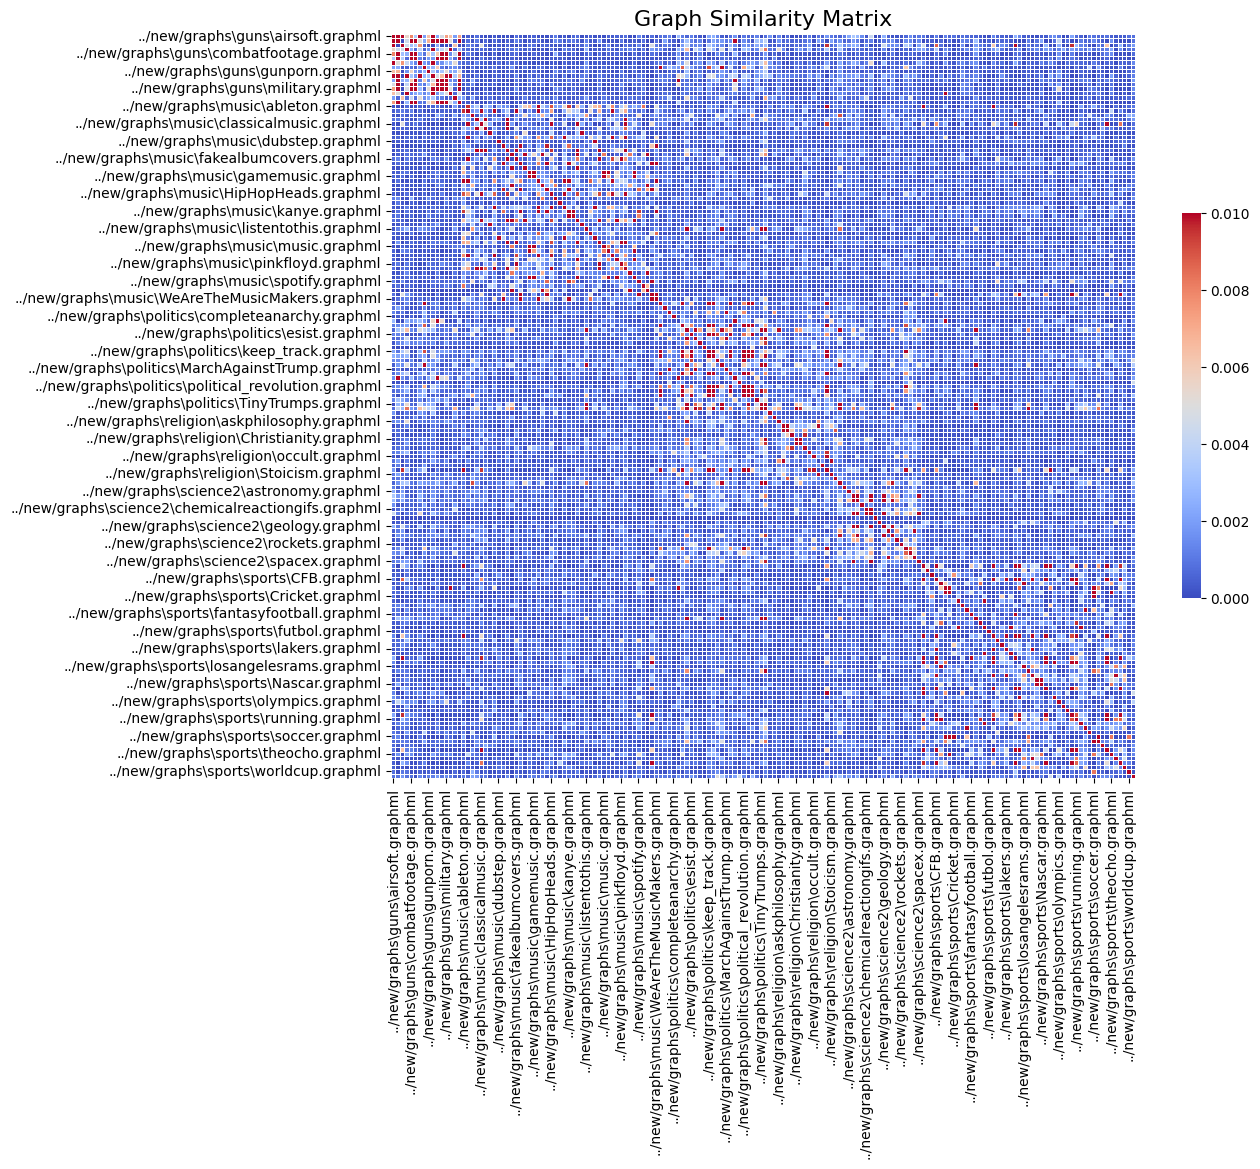

In [13]:
df = pd.DataFrame(similarity_matrix, columns=list_of_graphs, index=list_of_graphs)

plt.figure(figsize=(12, 10))

# Choose a colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

vmin, vmax = 0, 0.01 

# Draw the heatmap
sns.heatmap(df, cmap=cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Graph Similarity Matrix', fontsize=16)
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)

plt.show()


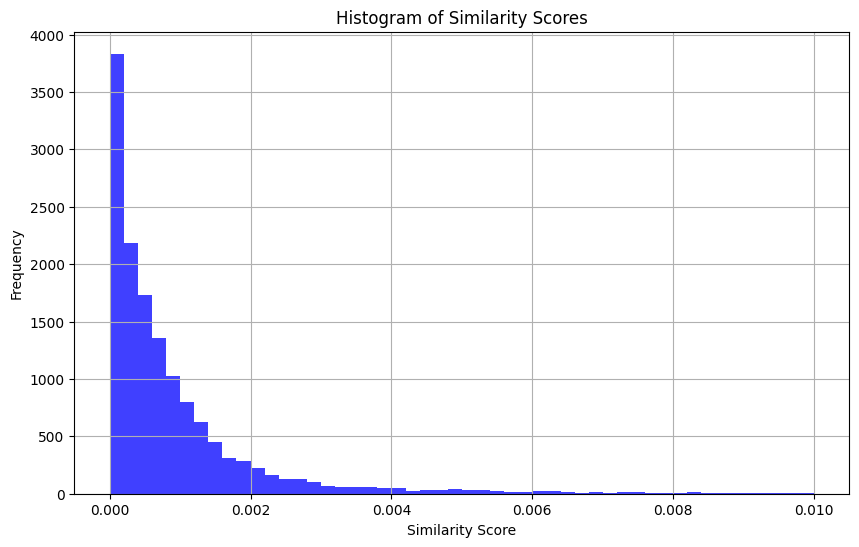

In [34]:
similarity_matrix = np.array(similarity_matrix)
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2

np.fill_diagonal(similarity_matrix, 0) # Remove self-similarities

# Flatten the matrix and remove zero values (self-similarities already removed)
similarity_scores = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=50, alpha=0.75, color='blue', range=(0, 0.01))
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

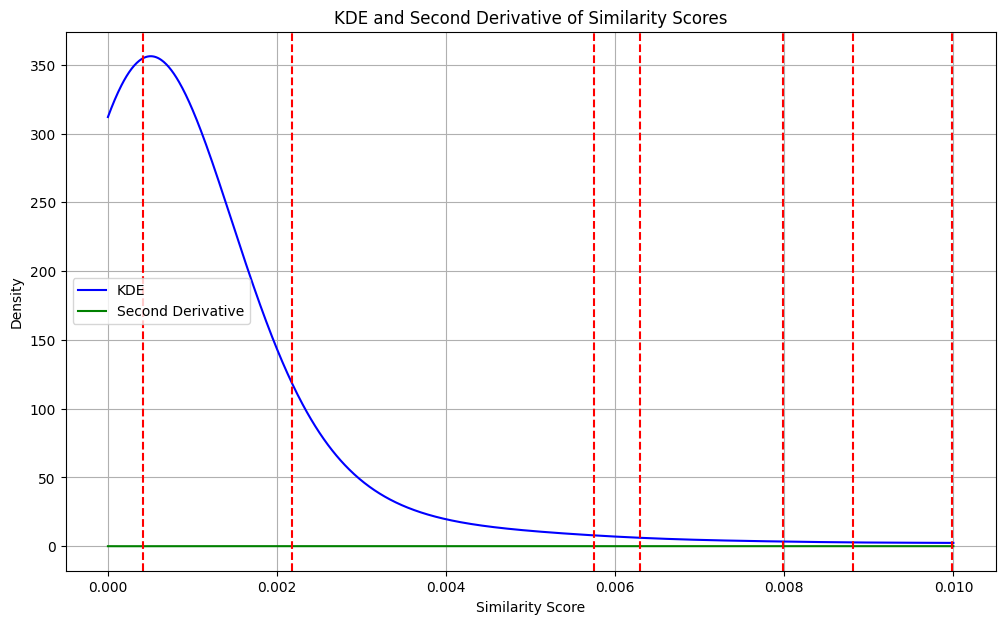

array([0.00217217, 0.0062963 , 0.00880881, 0.00042042, 0.00574575,
       0.00798799, 0.00997998])

In [50]:
# Step 1: KDE to estimate the probability density function
kde = gaussian_kde(similarity_scores)
x_grid = np.linspace(0, 0.01, 1000)  # Define a grid over our range of interest
kde_pdf = kde.evaluate(x_grid)

# Step 2: Calculate the second derivative
kde_pdf_second_derivative = np.gradient(np.gradient(kde_pdf))

# Step 3: Identify inflection points (changes in the sign of the second derivative)
# We're interested in local minima and maxima as potential inflection points
inflection_points_indices = argrelextrema(kde_pdf_second_derivative, np.greater)[0]  # Local maxima
inflection_points_indices = np.append(inflection_points_indices, argrelextrema(kde_pdf_second_derivative, np.less)[0])  # Local minima
inflection_points = x_grid[inflection_points_indices]

# Plotting for visualization
plt.figure(figsize=(12, 7))

# KDE plot
plt.plot(x_grid, kde_pdf, label='KDE', color='blue')

# Second derivative plot
plt.plot(x_grid, kde_pdf_second_derivative, label='Second Derivative', color='green')

# Mark inflection points
for inflection_point in inflection_points:
    plt.axvline(x=inflection_point, color='red', linestyle='--')

plt.title('KDE and Second Derivative of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

inflection_points